In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# ignore information messages from tensorflow, but we will receive error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

def load_custom_dataset(dataset_path, img_size=(224, 224)):
    """
    Load custom dataset from directory structure

    Args:
        dataset_path: Path to dataset directory containing train/ and test/
        img_size: Tuple of (height, width) to resize images to

    Returns:
        (X_train, Y_train), (X_test, Y_test), label_encoder
    """

    def load_images_from_folder(folder_path):
        images = []
        labels = []

        # Get all class folders
        class_names = sorted([d for d in os.listdir(folder_path)
                            if os.path.isdir(os.path.join(folder_path, d))])

        print(f"Found classes: {class_names}")

        for class_name in class_names:
            class_folder = os.path.join(folder_path, class_name)

            # Get all image files
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"Loading {len(image_files)} images from {class_name}...")

            for img_file in image_files:
                img_path = os.path.join(class_folder, img_file)

                try:
                    # Load and resize image
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)

                    images.append(img_array)
                    labels.append(class_name)

                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

        return np.array(images), np.array(labels)

    # Load train and test data
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    print("Loading training data...")
    X_train, Y_train_names = load_images_from_folder(train_path)

    print("\nLoading test data...")
    X_test, Y_test_names = load_images_from_folder(test_path)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([Y_train_names, Y_test_names]))

    Y_train = label_encoder.transform(Y_train_names).reshape(-1, 1)
    Y_test = label_encoder.transform(Y_test_names).reshape(-1, 1)

    print(f"\nClass mapping:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {i}: {class_name}")

    return (X_train, Y_train), (X_test, Y_test), label_encoder



In [4]:
# Load your custom dataset
dataset_path = '/content/drive/MyDrive/dataset-v2'  # Change this to your dataset path
(X_train, Y_train), (X_test, Y_test), label_encoder = load_custom_dataset(dataset_path, img_size=(224, 224))

print(f"\nDataset loaded successfully!")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Get class names
class_names = label_encoder.classes_
print(f"Classes: {class_names}")


Loading training data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 154 images from avoy...
Loading 145 images from navin...
Loading 156 images from rakin...
Loading 145 images from yousha...

Loading test data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 4 images from avoy...
Loading 5 images from navin...
Loading 4 images from rakin...
Loading 5 images from yousha...

Class mapping:
  0: avoy
  1: navin
  2: rakin
  3: yousha

Dataset loaded successfully!
X_train shape: (600, 224, 224, 3), Y_train shape: (600, 1)
X_test shape: (18, 224, 224, 3), Y_test shape: (18, 1)
Classes: ['avoy' 'navin' 'rakin' 'yousha']


In [5]:
# Create random indices
train_indices = np.random.permutation(len(X_train))

# Shuffle both X_train and Y_train using the same indices
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]

print(f"\nData shuffled successfully!")
print(f"X_train shape after shuffle: {X_train.shape}")
print(f"Y_train shape after shuffle: {Y_train.shape}")

# Create random indices
test_indices = np.random.permutation(len(X_test))

# Shuffle both X_train and Y_train using the same indices
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

print(f"\nData shuffled successfully!")
print(f"X_test shape after shuffle: {X_test.shape}")
print(f"Y_test shape after shuffle: {Y_test.shape}")



Data shuffled successfully!
X_train shape after shuffle: (600, 224, 224, 3)
Y_train shape after shuffle: (600, 1)

Data shuffled successfully!
X_test shape after shuffle: (18, 224, 224, 3)
Y_test shape after shuffle: (18, 1)


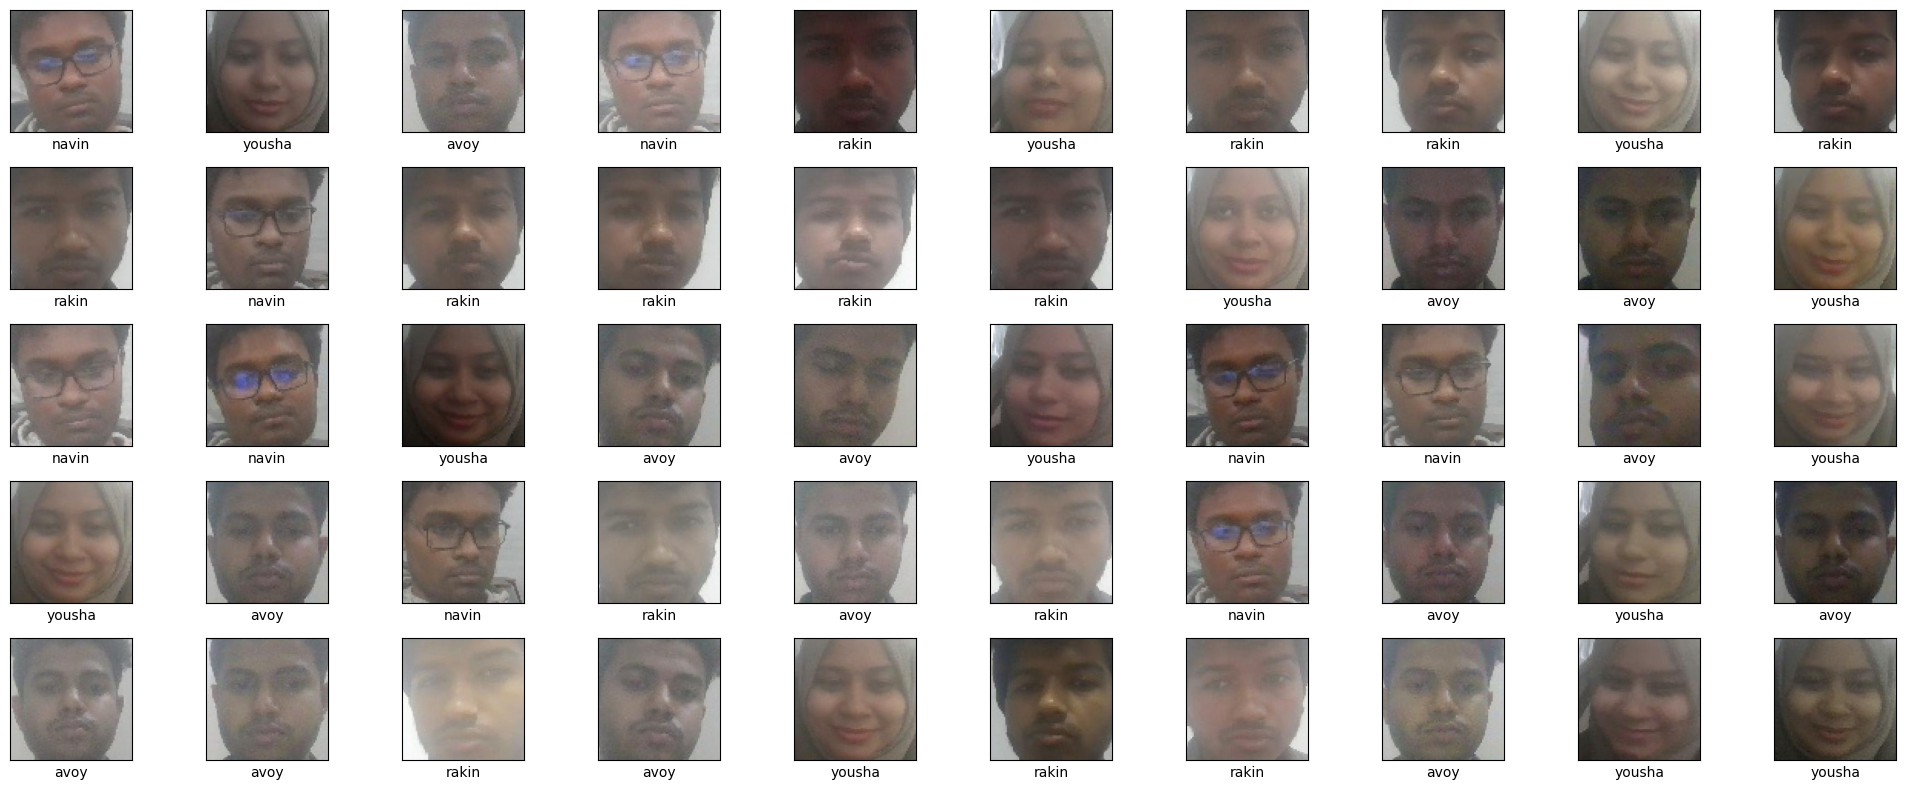

In [6]:
num_samples = min(50, len(X_train))  # Show up to 50 samples
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[Y_train[i][0]])
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [8]:
num_classes = len(class_names)

model = keras.Sequential([
    ## input layer (224x224x3 for your custom images)
    keras.Input(shape=(224, 224, 3)),

    ## hidden layers
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),

    ## output layer (4 classes: avoy, rakin, yousha, navin)
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697,540 (2.66 MB)

 Trainable params: 697,540 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# If Navin still dominates, be more aggressive
class_weight_dict = {
    0: 2.0,  # avoy
    1: 2.0,  # rakin
    2: 2.0,  # yousha
    3: 0.3   # navin - heavily penalize
}

print("\nAggressive weights:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weight_dict[i]}")

h = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict
)



Aggressive weights:
  avoy: 2.0
  navin: 2.0
  rakin: 2.0
  yousha: 0.3
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.2700 - loss: 2.1952 - val_accuracy: 0.2417 - val_loss: 1.4460
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2172 - loss: 2.0565 - val_accuracy: 0.3167 - val_loss: 1.4618
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2362 - loss: 1.9909 - val_accuracy: 0.2500 - val_loss: 1.4772
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2507 - loss: 1.9779 - val_accuracy: 0.2500 - val_loss: 1.5917
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2726 - loss: 1.9298 - val_accuracy: 0.4333 - val_loss: 1.3006
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4143 - loss: 1.7255 - val_accuracy: 0.5667 - val_loss: 0.9597
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6097 - loss: 1.0655 - val_accuracy: 0.7000 - val_loss: 0.6546
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━

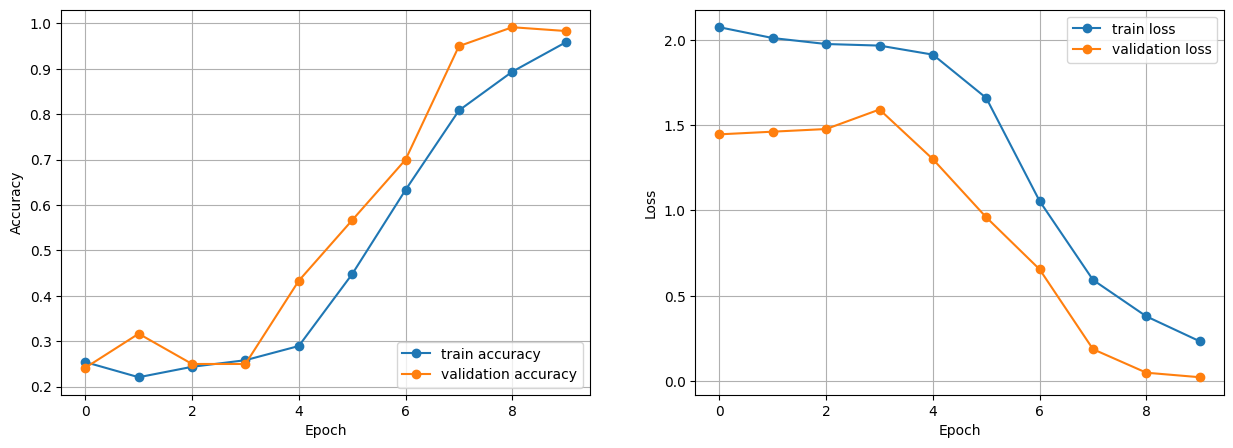

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [12]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0611

Test Accuracy: 1.0

Test Loss: 0.06114808842539787


In [13]:
predictions = model.predict(X_test)

print("\nFirst prediction probabilities:")
print(predictions[0])
print(f"Predicted class: {class_names[np.argmax(predictions[0])]}")
print(f"Actual class: {class_names[Y_test[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step

First prediction probabilities:
[0.14280863 0.11231945 0.13795468 0.60691726]
Predicted class: yousha
Actual class: yousha


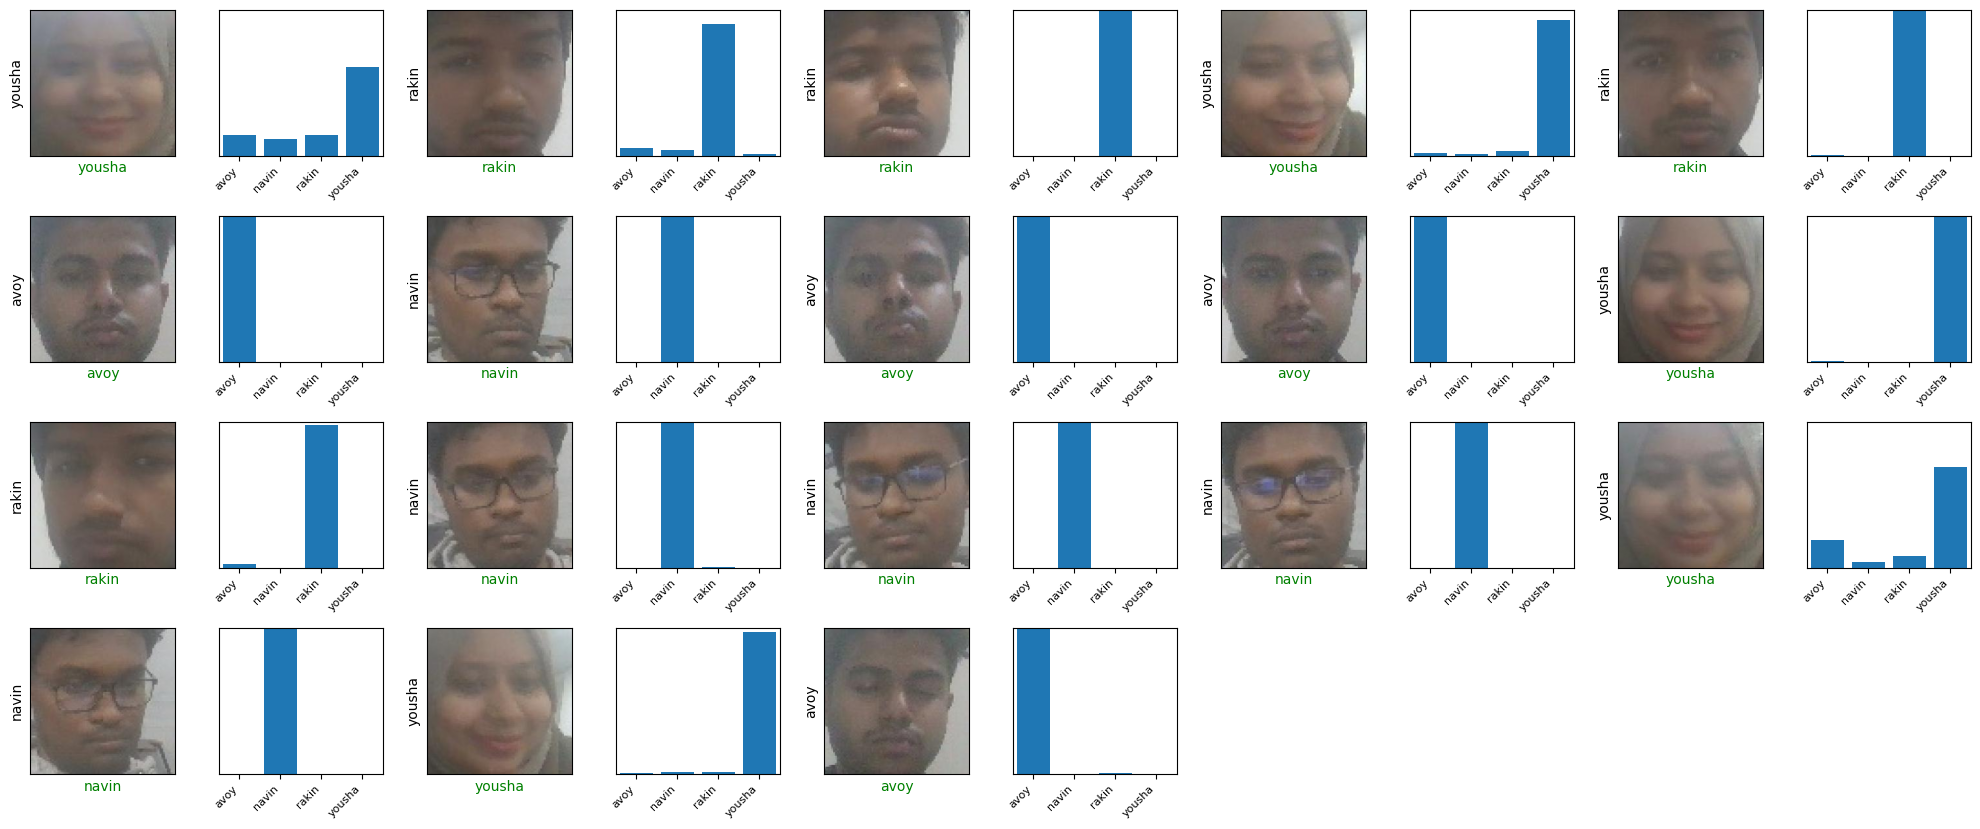

In [14]:
num_predictions = min(25, len(X_test))
rows = 5
cols = 5

plt.figure(figsize=(20, 10))
for i in range(num_predictions):
    # Show image
    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_names[Y_test[i][0]])

    # Color code predictions: green if correct, red if incorrect
    if Y_test[i][0] == np.argmax(predictions[i]):
        plt.xlabel(class_names[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(class_names[np.argmax(predictions[i])], color='r')

    # Show prediction bar chart
    plt.subplot(rows, 2*cols, 2*i+2)
    plt.bar(range(num_classes), predictions[i])
    plt.yticks([])
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right', fontsize=8)
    plt.ylim([0, 1])
    plt.xlim([-0.5, num_classes-0.5])

plt.tight_layout()
plt.show()

In [15]:
# Save the trained model
model_path = 'face_recognition_model.h5'
model.save(model_path)
print(f"\nModel saved successfully to: {model_path}")

# Save the label encoder for later use
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to: label_encoder.pkl")



Model saved successfully to: face_recognition_model.h5
Label encoder saved to: label_encoder.pkl
